# NOTES

# IMPORTS

In [1]:
# Dataset
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from scipy.io import loadmat
from imutils import paths
import numpy as np
import imutils
import cv2
import os

# Architecture
from keras import models
from keras import layers
from keras import backend as K
from keras.utils import plot_model

# Compilation
from keras.optimizers import SGD

# Training
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

# Plotting
import matplotlib.pyplot as plt

# Prediction
from sklearn.metrics import classification_report

Using TensorFlow backend.


# HELPER FUNCTIONS

## Path extractor

In [2]:
def path_extractor(paths, list_index):
    data_path = []
    
    for (i, path) in enumerate(paths):
        for index in list_index:
            if i == index:
                data_path.append(path)
    
    return data_path

## Label extractor

In [3]:
def label_extractor(paths):
    labels = []
    
    for path in paths:
        path = os.path.split(path)[-1][:-9]
        labels.append(path)
    
    return labels

## Image loader

In [4]:
def load_images(images_path, verbose=1):
    images = []
    
    print('[INFO] loading...')
    for (i, path) in enumerate(images_path):
        image = cv2.imread(path)
        images.append(image)
        
        if i > 0 and verbose > 0 and (i + 1) % verbose == 0:
            print('[INFO] loaded {}/{}'.format((i + 1), len(images_path)))
    
    # convert images list to numpy array
    images = np.array(images)
    
    return images

# DATASET

## Variables

In [5]:
# Path
index_url = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/datasplit/datasplits.mat'
flowers_url = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/'

# Binarization
lb = LabelBinarizer()

## Load data index and images path

In [6]:
# load data index
dataset_index = loadmat(index_url)

train_index = dataset_index['trn3']
test_index = dataset_index['tst3']
val_index = dataset_index['val3']

# load images path
flowers_path = list(paths.list_images(flowers_url))

### Path split

In [7]:
# Deduce train, test and validation paths
train_index = list(train_index[0])
test_index = list(test_index[0])
val_index = list(val_index[0])

train_path = path_extractor(flowers_path, train_index)
test_path = path_extractor(flowers_path, test_index)
val_path = path_extractor(flowers_path, val_index)

train_path

['C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (06).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (08).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (09).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (12).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (13).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (15).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/flower17/images/Bluebell (16).jpg',
 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learn

## Labels

### Extraction

In [8]:
train_labels = label_extractor(train_path)
test_labels = label_extractor(test_path)
val_labels = label_extractor(val_path)

train_labels

['Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Bluebell',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'Buttercup',
 'B

### Binarization

In [9]:
trainY = lb.fit_transform(train_labels)
testY = lb.fit_transform(test_labels)
valY = lb.fit_transform(val_labels)

## Data

### Preprocessors

In [10]:
class Preprocessors:
    # constructor
    def __init__(self, width, height, inter=cv2.INTER_AREA, dataFormat=None):
        # resize
        self.width = width
        self.height = height
        self.inter = inter
        
        # image to array
        self.dataFormat = dataFormat
    
    # resize processor
    def resizer(self, image):      
        # RESIZE        
        # grab heights and widths of an image, then initialize delta used when cropping
        (h, w) = image.shape[:2]
        dH = 0
        dW = 0
                
        # check if w is smaller than h and resize along it
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)
        else: 
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)
            
        # CROPPING
        # regrab height and width again and crop the image along the longest dimension
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]
        
        # resize image to the given spatial dimension
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)
    
    # image to array processor
    def img2array(self, image):
        return img_to_array(image, data_format=self.dataFormat)
    
    # image processor
    def img_data(self, img_list, verbose=1):
        data = []
        
        print('[INFO] processing...')
        for (i, image) in enumerate(img_list):
            image = self.resizer(image)
            image = self.img2array(image)
            data.append(image)
            
            if i > 0 and verbose > 0 and (i +1) % verbose == 0:
                print('[INFO] processed {}/{}'.format((i + 1), len(img_list)))
        
        data = np.array(data)
        
        # scalling
        data = data.astype('float') / 255.0
        
        return data
            
        



### Images

In [11]:
train_images = load_images(train_path, verbose=100)
print()
test_images = load_images(test_path, verbose=50)
print()
val_images = load_images(val_path, verbose=50)


[INFO] loading...
[INFO] loaded 100/679
[INFO] loaded 200/679
[INFO] loaded 300/679
[INFO] loaded 400/679
[INFO] loaded 500/679
[INFO] loaded 600/679


C:\Users\Tajr\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]



[INFO] loading...
[INFO] loaded 50/340
[INFO] loaded 100/340
[INFO] loaded 150/340
[INFO] loaded 200/340
[INFO] loaded 250/340
[INFO] loaded 300/340

[INFO] loading...
[INFO] loaded 50/340
[INFO] loaded 100/340
[INFO] loaded 150/340
[INFO] loaded 200/340
[INFO] loaded 250/340
[INFO] loaded 300/340


### Images data

In [12]:
# initialize image processor
processor = Preprocessors(width=64, height=64, dataFormat=None, inter=cv2.INTER_AREA)
trainX = processor.img_data(train_images, verbose=100)
print()
testX = processor.img_data(test_images, verbose=50)
print()
valX =  processor.img_data(val_images, verbose=50)

[INFO] processing...
[INFO] processed 100/679
[INFO] processed 200/679
[INFO] processed 300/679
[INFO] processed 400/679
[INFO] processed 500/679
[INFO] processed 600/679

[INFO] processing...
[INFO] processed 50/340
[INFO] processed 100/340
[INFO] processed 150/340
[INFO] processed 200/340
[INFO] processed 250/340
[INFO] processed 300/340

[INFO] processing...
[INFO] processed 50/340
[INFO] processed 100/340
[INFO] processed 150/340
[INFO] processed 200/340
[INFO] processed 250/340
[INFO] processed 300/340


### Data shuffling

In [13]:
(trainX, trainY) = shuffle(trainX, trainY)
(testX, testY) = shuffle(testX, testY)
(valX, valY) = shuffle(valX, valY)

# ARCHITECTURE

## Variables

In [14]:
width = 64
height = 64
depth = 3
classes=17
channels_dim = -1
pool_size = (2, 2)
pool_strides = (2, 2)
conv_strides = (3, 3)
filter_01 = 32
filter_02 = 64
input_shape = (width, height, depth)

# configure input shape
if K.image_data_format == 'channels_first':
    input_shape = (depth, width, height)
    channels_dim = 1

## Architecture definition

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(filter_01, conv_strides, padding='same', input_shape=input_shape))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Conv2D(filter_01, conv_strides, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(filter_02, conv_strides, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Conv2D(filter_02, conv_strides, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization(axis=channels_dim))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(classes))
model.add(layers.Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)       

## Diagram

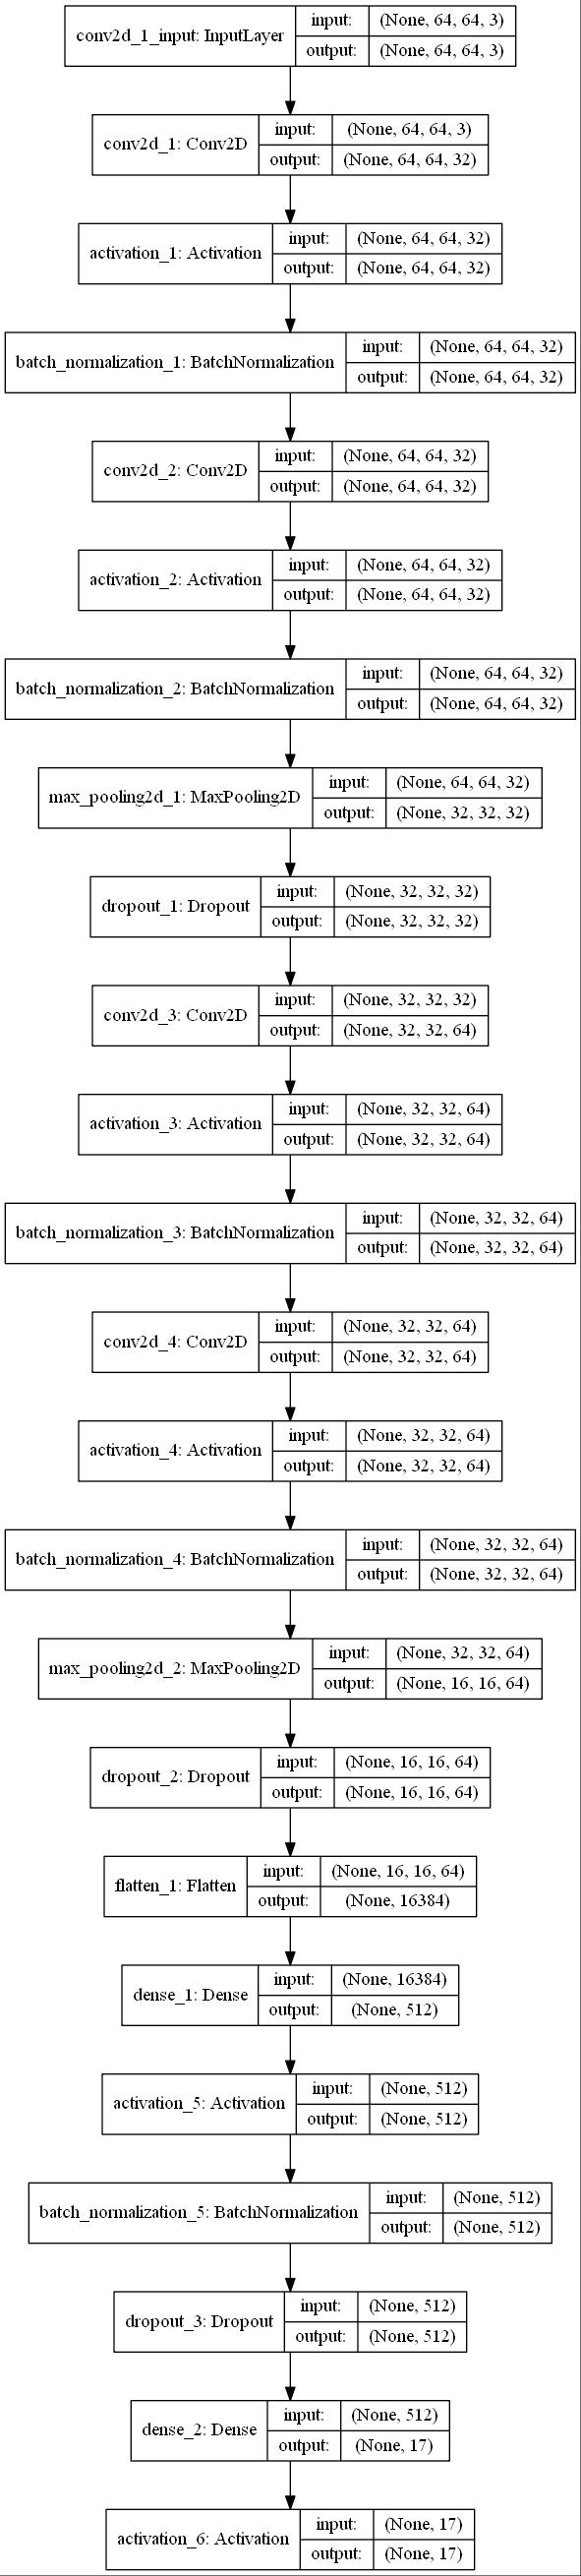

In [16]:
plot_model(model, to_file='serialized/architecture/architecture.jpg', show_shapes=True)

# COMPILATION

## Variables

In [17]:
learning_rate = 0.05
epch = 100

## LR scheduling

### Normal

In [18]:
opt_normal = SGD(lr=learning_rate)

### Time based scheduling

In [19]:
opt_time = SGD(lr=learning_rate, decay=learning_rate/epch, momentum=0.9, nesterov=True)

### Step decay

In [20]:
opt_step = opt_normal

def step_decay(epoch):
    initialAlpha = learning_rate
    factor = 0.25
    dropEvery = 5
    
    # compute alpha
    alpha = initialAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    
    return float(alpha)

## Compile

In [21]:
model.compile(optimizer=opt_time, loss='categorical_crossentropy', metrics=['acc'])

# TRAINING

## Variables

In [22]:
augmented = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Computer Vision/imagelab/nn/conv/VGGNET Family/Flower17/augmented/'
prefix = 'image'

## Data augmentation

In [23]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

## Callbacks registration

In [24]:
callbacks = [LearningRateScheduler(step_decay)]

## Train

In [25]:
# Without data augmentation
history = model.fit(trainX, trainY, epochs=epch, batch_size=32, validation_data=(valX, valY))

# With data augmentation
# history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32), epochs=epch, steps_per_epoch=len(trainX) // 32, callbacks=callbacks, validation_data=(valX, valY))

Train on 679 samples, validate on 340 samples
Epoch 1/100
679/679 [==============================] - 10s 15ms/step - loss: 3.6490 - acc: 0.2533 - val_loss: 778.6508 - val_acc: 0.1294
Epoch 2/100
679/679 [==============================] - 5s 7ms/step - loss: 2.8695 - acc: 0.3711 - val_loss: 416.0106 - val_acc: 0.1059
Epoch 3/100
679/679 [==============================] - 5s 7ms/step - loss: 2.6581 - acc: 0.4065 - val_loss: 266.9028 - val_acc: 0.0706
Epoch 4/100
679/679 [==============================] - 5s 7ms/step - loss: 2.2109 - acc: 0.4345 - val_loss: 88.2694 - val_acc: 0.1147
Epoch 5/100
679/679 [==============================] - 5s 7ms/step - loss: 1.5045 - acc: 0.5920 - val_loss: 30.0093 - val_acc: 0.1735
Epoch 6/100
679/679 [==============================] - 5s 7ms/step - loss: 1.1943 - acc: 0.6436 - val_loss: 11.9001 - val_acc: 0.2088
Epoch 7/100
679/679 [==============================] - 5s 8ms/step - loss: 0.9204 - acc: 0.7290 - val_loss: 10.2919 - val_acc: 0.2382
Epoch 8/100

Epoch 62/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0199 - acc: 0.9897 - val_loss: 3.7549 - val_acc: 0.5118
Epoch 63/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0157 - acc: 0.9941 - val_loss: 3.7233 - val_acc: 0.5176
Epoch 64/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0107 - acc: 0.9956 - val_loss: 3.8415 - val_acc: 0.5059
Epoch 65/100
679/679 [==============================] - 6s 9ms/step - loss: 0.0210 - acc: 0.9926 - val_loss: 3.7968 - val_acc: 0.4853
Epoch 66/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0108 - acc: 0.9956 - val_loss: 3.6821 - val_acc: 0.4971
Epoch 67/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0100 - acc: 0.9971 - val_loss: 3.6180 - val_acc: 0.5118
Epoch 68/100
679/679 [==============================] - 5s 7ms/step - loss: 0.0082 - acc: 0.9971 - val_loss: 3.6494 - val_acc: 0.5029
Epoch 69/100
679/679 [==============================] - 5s 7ms

# PLOTTING

## Variables

In [26]:
history_dict = history.history
epochs = np.arange(1, (len(history_dict['acc']) + 1))

accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

## Accuracy

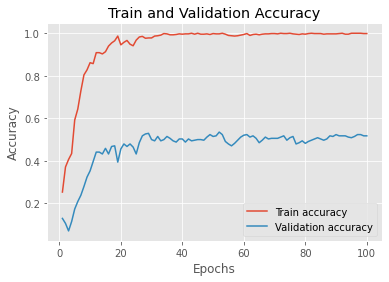

In [27]:
plt.style.use('ggplot')
plt.plot(epochs, accuracy, label='Train accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss

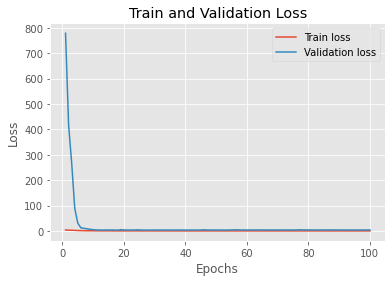

In [28]:
plt.clf()
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION

In [29]:
results = model.evaluate(testX, testY)
results

340/340 [==============================] - 1s 2ms/step


[3.4888369335847744, 0.49705880880355835]

# PREDICTIONS

In [30]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names= [str(x) for x in lb.classes_]))

              precision    recall  f1-score   support

    Bluebell       0.48      0.60      0.53        20
   Buttercup       0.53      0.40      0.46        20
  Colts Foot       0.44      0.60      0.51        20
     Cowslip       0.32      0.40      0.36        20
      Crocus       0.37      0.50      0.43        20
     Daffodi       0.50      0.35      0.41        20
       Daisy       0.52      0.60      0.56        20
   Dandelion       0.67      0.60      0.63        20
  Fritillary       0.50      0.40      0.44        20
        Iris       0.90      0.90      0.90        20
 Lily Valley       0.50      0.40      0.44        20
       Pansy       0.44      0.40      0.42        20
    Snowdrop       0.40      0.40      0.40        20
   Sunflower       0.94      0.80      0.86        20
   Tigerlily       0.43      0.45      0.44        20
       Tulip       0.27      0.20      0.23        20
  Windflower       0.39      0.45      0.42        20

    accuracy              

# OBSERVATIONS